# Scrap Data from KCDC

## Import

In [662]:
%matplotlib inline

# for figure
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import seaborn as sns
sns.set(color_codes=True, font_scale=1.33)

import pandas as pd
import numpy as np

import shutil
# importing os module
import os
# import datetime module
import datetime

import re

# for geo lat/lon
from geopy.geocoders import Nominatim

## Definitions

In [720]:
pd.options.display.max_rows = 100
# your path folder to save results
PATH_FOLDER_SAVE = '../../data'

PATH_CSV_DATA = PATH_FOLDER_SAVE + '/data.csv'
PATH_CSV_DF_GEO_KOR = 'df_geo_kor.csv'

PATH_PAGES_KCDC_UPDATES = os.getcwd() + '/pages_kcdc_updates.json'

PATH_TABLES_KCDC_UPDATES = os.getcwd() + '/tables_kcdc_updates.json'

LIST_AREA = ["Seoul",
"Busan",
"Daegu",
"Incheon",
"Gwangju",
"Daejeon",
"Ulsan",
"Sejong",
"Gyeonggi",
"Gangwon",
"Chungbuk",
"Chungnam",
"Cheonbuk",
"Cheonnam",
"Gyeongbuk",
"Gyeongnam",
"Jeju"]

LIST_STR_TO_FIND = ["COVID",
                    "Coronavirus",
                    "coronavirus",
                   "additional cases"]



## Helper functions

In [664]:
# save before scraping
def clean_file(path_file_name):
    '''
    Clean file already traited : rename file with date
    '''
    try:
        d = datetime.datetime.now()
        str_date = '_' + d.strftime("%Y%m%d_%H_%M_%S")
       
        res_re = re.search('\.\w+$', path_file_name)
        
        path_file_name_saved = \
            path_file_name[0:res_re.start()] + str_date + res_re.group(0)
         
        shutil.move(path_file_name, path_file_name_saved) 
        print('File {} moved!'.format(path_file_name_saved))
    except:
        print('File {} does not exist!'.format(path_file_name))


In [665]:
import scrapy
import scrapy.crawler as crawler
from multiprocessing import Process, Queue
from twisted.internet import reactor

# the wrapper to make it run more times
def run_spider(spider):
    '''
    DOESNT WORK WITH LAST VERSION OF SCRAPY OR TWISTED ??? 
    BUG
    function to run several times scraping process
    '''
    def f(q):
        try:
            runner = crawler.CrawlerRunner()
            deferred = runner.crawl(spider)
            deferred.addBoth(lambda _: reactor.stop())
            reactor.run()
            q.put(None)
        except Exception as e:
            q.put(e)

    q = Queue()
    p = Process(target=f, args=(q,))
    p.start()
    result = q.get()
    p.join()

    if result is not None:
        raise result


In [666]:
def convert_int(val_curr):
    '''
    To convert in integer if not NaN
    '''
    if np.isnan(val_curr):
        return val_curr
    else:
        return int(val_curr)

## South Korea : Scrap Data from KCDC

### Scrap pages links

In [775]:
%%writefile kcdcspider.py
# -*-coding:utf-8 -*

#
# Class to scrap KCDC Tables values for each town/area in South Korea
#

#import
import re
import scrapy

# definitions
URL_ROOT = 'https://www.cdc.go.kr'
NUM_MAX_PAGES = 10
PATH_OUTPUT = 'pages_kcdc_updates.json'
URL_FIRST_PAGE = URL_ROOT + '/board.es?mid=a30402000000&bid=0030&nPage=1'

LIST_STR_TO_FIND = ["COVID",
                    "Coronavirus",
                    "coronavirus",
                   "additional cases"]

# Spider Class
class KCDCPageSpider(scrapy.Spider):
    '''
    Spider to scrap all Le Gorafi pages from selected category
    Configure : 
    - KCDCPageSpider.custom_settings : save location 
    - num_max_pages : the number of next page to scrap
    - url_first_page : web page to start with
    '''
    name = "kcdc_updates_page"
    
    custom_settings = {
      'FEED_FORMAT': 'json',
      'FEED_URI': PATH_OUTPUT
    }
    
    num_max_pages = NUM_MAX_PAGES
    
    url_first_page = URL_FIRST_PAGE
    
    def start_requests(self):
        urls = [
                self.url_first_page,
        ]
        for url in urls:
            yield scrapy.Request(url=url, callback=self.parse)
    
    def parse(self, response):
        str_pattern = '//div[@class="dbody"]/ul/li/a[contains(@title,"{}")]'
        str_search = ''
        for str_curr in LIST_STR_TO_FIND:
            str_search = str_search + str_pattern.format(str_curr) + '|'
        str_search = str_search[0:-1]
        #'//div[@class="dbody"]/ul/li/a[contains(@title,"updates")]|' + \
        #    '//div[@class="dbody"]/ul/li/a[contains(@title,"Updates")]'
        for post in response.xpath(str_search):
            yield {
                'link': URL_ROOT + post.xpath('@href').extract_first()
            }
        # https://www.cdc.go.kr/board.es?mid=a30402000000&bid=0030&nPage=2
        #//a[@class="pageNext"]/@href
        next_page = response.xpath('//a[@class="pageNext"]/@href').get()
        
        if next_page is not None:
            try:
                num_next_page = int(re.search("(?<=\&nPage\=)\d+$", 
                         next_page).group(0))
                
                if (num_next_page < self.num_max_pages):
                    #next_page = response.urljoin(next_page)
                    next_page = URL_ROOT + next_page
                    yield scrapy.Request(next_page, callback=self.parse)
            except:
                next_page = None

Overwriting kcdcspider.py


In [776]:
%%writefile run_kcdc_pages_updates.py
# -*-coding:utf-8 -*

#
# Run scrapy for retrieve updates pages links from KCDC
#

# import
import scrapy
from scrapy.crawler import CrawlerProcess
from kcdcspider import KCDCPageSpider

process = CrawlerProcess()

process.crawl(KCDCPageSpider)
process.start() # the script will block here until the crawling is finished

Overwriting run_kcdc_pages_updates.py


In [777]:
%%time
try:
    # clean (move file if exist)
    clean_file(PATH_PAGES_KCDC_UPDATES)
    # execute external process (FALLBACK for scrapy problem)
    !python run_kcdc_pages_updates.py 
except:
    print("Error run_kcdc_pages_updates !")

File /Users/gregory/Documents/CloudStationSinchon/Applications/python/CoronaVirus/code/coronavirusModel/pages_kcdc_updates_20200302_20_28_24.json moved!
2020-03-02 20:28:25 [scrapy.utils.log] INFO: Scrapy 1.8.0 started (bot: scrapybot)
2020-03-02 20:28:25 [scrapy.utils.log] INFO: Versions: lxml 4.5.0.0, libxml2 2.9.9, cssselect 1.1.0, parsel 1.5.2, w3lib 1.21.0, Twisted 19.10.0, Python 3.7.6 (default, Jan  8 2020, 13:42:34) - [Clang 4.0.1 (tags/RELEASE_401/final)], pyOpenSSL 19.1.0 (OpenSSL 1.1.1d  10 Sep 2019), cryptography 2.8, Platform Darwin-18.7.0-x86_64-i386-64bit
2020-03-02 20:28:25 [scrapy.crawler] INFO: Overridden settings: {'FEED_FORMAT': 'json', 'FEED_URI': 'pages_kcdc_updates.json'}
2020-03-02 20:28:25 [scrapy.extensions.telnet] INFO: Telnet Password: a2ea1a629dad5421
2020-03-02 20:28:25 [scrapy.middleware] INFO: Enabled extensions:
['scrapy.extensions.corestats.CoreStats',
 'scrapy.extensions.telnet.TelnetConsole',
 'scrapy.extensions.memusage.MemoryUsage',
 'scrapy.extens

2020-03-02 20:28:27 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.cdc.go.kr/board.es?mid=a30402000000&bid=0030&nPage=4> (referer: https://www.cdc.go.kr/board.es?mid=a30402000000&bid=0030&nPage=3)
2020-03-02 20:28:27 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.cdc.go.kr/board.es?mid=a30402000000&bid=0030&nPage=4>
{'link': 'https://www.cdc.go.kr/board/board.es?mid=a30402000000&bid=0030&act=view&list_no=366276&tag=&nPage=4'}
2020-03-02 20:28:27 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.cdc.go.kr/board.es?mid=a30402000000&bid=0030&nPage=4>
{'link': 'https://www.cdc.go.kr/board/board.es?mid=a30402000000&bid=0030&act=view&list_no=366264&tag=&nPage=4'}
2020-03-02 20:28:27 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.cdc.go.kr/board.es?mid=a30402000000&bid=0030&nPage=4>
{'link': 'https://www.cdc.go.kr/board/board.es?mid=a30402000000&bid=0030&act=view&list_no=366261&tag=&nPage=4'}
2020-03-02 20:28:27 [scrapy.core.scraper] DEBUG: Scraped

2020-03-02 20:28:29 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.cdc.go.kr/board.es?mid=a30402000000&bid=0030&nPage=8> (referer: https://www.cdc.go.kr/board.es?mid=a30402000000&bid=0030&nPage=7)
2020-03-02 20:28:29 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.cdc.go.kr/board.es?mid=a30402000000&bid=0030&nPage=8>
{'link': 'https://www.cdc.go.kr/board/board.es?mid=a30402000000&bid=0030&act=view&list_no=365933&tag=&nPage=8'}
2020-03-02 20:28:29 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.cdc.go.kr/board.es?mid=a30402000000&bid=0030&nPage=8>
{'link': 'https://www.cdc.go.kr/board/board.es?mid=a30402000000&bid=0030&act=view&list_no=365926&tag=&nPage=8'}
2020-03-02 20:28:29 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.cdc.go.kr/board.es?mid=a30402000000&bid=0030&nPage=8>
{'link': 'https://www.cdc.go.kr/board/board.es?mid=a30402000000&bid=0030&act=view&list_no=365915&tag=&nPage=8'}
2020-03-02 20:28:29 [scrapy.core.scraper] DEBUG: Scraped

In [778]:
df_pages_kcdc_updates = pd.read_json(PATH_PAGES_KCDC_UPDATES)
print("Nb news : ", df_pages_kcdc_updates.shape[0])
df_pages_kcdc_updates

Nb news :  77


,link
0,https://www.cdc.go.kr/board/board.es?mid=a3040...
1,https://www.cdc.go.kr/board/board.es?mid=a3040...
2,https://www.cdc.go.kr/board/board.es?mid=a3040...
3,https://www.cdc.go.kr/board/board.es?mid=a3040...
4,https://www.cdc.go.kr/board/board.es?mid=a3040...
5,https://www.cdc.go.kr/board/board.es?mid=a3040...
6,https://www.cdc.go.kr/board/board.es?mid=a3040...
7,https://www.cdc.go.kr/board/board.es?mid=a3040...
8,https://www.cdc.go.kr/board/board.es?mid=a3040...
9,https://www.cdc.go.kr/board/board.es?mid=a3040...


In [779]:
# TODO ?
'''# configure scraping
KCDCPageSpider.url_first_page = URL_PAGES_KCDC_UPDATES
KCDCPageSpider.custom_settings = {
      'FEED_FORMAT': 'json',
      'FEED_URI': URL_PAGES_KCDC_UPDATES
    }
KCDCPageSpider.num_max_pages = 1

# clean last output
clean_file(PATH_PAGES_KCDC_UPDATES)
# scraping page urls 
run_spider(KCDCPageSpider)'''
# DOES NOT WORK ANYMORE !


"# configure scraping\nKCDCPageSpider.url_first_page = URL_PAGES_KCDC_UPDATES\nKCDCPageSpider.custom_settings = {\n      'FEED_FORMAT': 'json',\n      'FEED_URI': URL_PAGES_KCDC_UPDATES\n    }\nKCDCPageSpider.num_max_pages = 1\n\n# clean last output\nclean_file(PATH_PAGES_KCDC_UPDATES)\n# scraping page urls \nrun_spider(KCDCPageSpider)"

### Scrap updates tables

In [780]:
%%writefile kcdctablespider.py
# -*-coding:utf-8 -*

#
# Module for scrapy over tables in KCDC
#

# import
import re
import scrapy
from scrapy.loader import ItemLoader
from scrapy.loader.processors import MapCompose, Join, TakeFirst
from w3lib.html import remove_tags


# definitions 
URL_ROOT = 'https://www.cdc.go.kr'
PATH_TABLES_OUTPUT = 'tables_kcdc_updates.json'
URL_FIRST_PAGE = URL_ROOT + '/board.es?mid=a30402000000&bid=0030&nPage=1'

LIST_AREA = ["Seoul",
"Busan",
"Daegu",
"Incheon",
"Gwangju",
"Daejeon",
"Ulsan",
"Sejong",
"Gyeonggi",
"Gangwon",
"Chungbuk",
"Chungnam",
"Cheonbuk",
"Cheonnam",
"Gyeongbuk",
"Gyeongnam",
"Jeju"]

def convert_int(str_in):
    # suppress ","
    str_in = re.sub(',', '', str_in)
    # convert in integer
    return int(str_in)

def find_in_table(response, n_row, n_col):
    search_str = '//tbody/tr/td/p/' + \
        'span[contains(., "Confirmed")]' + \
        '/../../../..//tr[{}]/td[{}]'.format(n_row, n_col) + \
        '/p/span[re:test(.,"^\d")]//text()'

    text_found = response.xpath(search_str).get()
    return text_found 




def find_int_in_table(response, n_row, n_col):
    text_found = find_in_table(response, n_row, n_col)
    if isinstance(text_found, str):
        return convert_int(text_found)
    else:
        return text_found


def find_int_area_in_table(response, area):
    
    flag_add = None
    
    search_str = '//tbody/tr[1]/td[1][contains(., "Regions")]/../../' + \
        'tr/td/p/span[contains(., "{}")]'.format(area) + \
        '/../../../td[2]/p/span[re:test(.,"^\d")]//text()'
    text_found = response.xpath(search_str).get()
    
    # if old style table (area in columns)
    if text_found is None:
        # search # of columns
        
        text_col = ''
        I_col_area = 1
        while text_col != None:
            search_str = '//tbody/tr[1]/td[1][contains(., "Place")]' + \
                '/../../tr[2]/td[{}]/p/span/text()'.format(I_col_area)
            text_col = response.xpath(search_str).get()
            if text_col == area:
                break
            I_col_area = I_col_area + 1
        
        search_str = '//tbody/tr[1]/td[1][contains(., "Place")]/../../' + \
            'tr/td/p/span[contains(., "{}")]'.format(area) + \
            '/../../../../tr[3]/td[{}]'.format(I_col_area + 1) + \
            '/p/span[re:test(.,"^\d")]//text()'  
        
        text_found = response.xpath(search_str).get()
        if text_found is not None:
            flag_add = True
    else:
        flag_add = False
        
    if isinstance(text_found, str):
        return flag_add, convert_int(text_found)
    else:
        return flag_add, text_found
    

class KCDCiItem(scrapy.Item):
    '''
    Class item to declare different information to scrap
    and how to process (as input or output)
    '''
    # define the fields for your item here like:
    url = scrapy.Field(output_processor=TakeFirst())
    
    source = scrapy.Field(output_processor=TakeFirst())
    
    date_published = scrapy.Field(
        input_processor=MapCompose(remove_tags),
        output_processor=TakeFirst()
    )
    
    total = scrapy.Field(output_processor=TakeFirst())
    
    flag_add = scrapy.Field(output_processor=TakeFirst())
    
    Seoul = scrapy.Field(output_processor=TakeFirst())   

    Busan = scrapy.Field(output_processor=TakeFirst())  
    Daegu = scrapy.Field(output_processor=TakeFirst())  
    Incheon = scrapy.Field(output_processor=TakeFirst())  
    Gwangju = scrapy.Field(output_processor=TakeFirst())  
    Daejeon = scrapy.Field(output_processor=TakeFirst())  
    Ulsan = scrapy.Field(output_processor=TakeFirst())  
    Sejong = scrapy.Field(output_processor=TakeFirst())  
    Gyeonggi = scrapy.Field(output_processor=TakeFirst())  
    Gangwon = scrapy.Field(output_processor=TakeFirst())  
    Chungbuk = scrapy.Field(output_processor=TakeFirst())  
    Chungnam = scrapy.Field(output_processor=TakeFirst())  
    Cheonbuk = scrapy.Field(output_processor=TakeFirst())  
    Cheonnam = scrapy.Field(output_processor=TakeFirst())  
    Gyeongbuk = scrapy.Field(output_processor=TakeFirst())  
    Gyeongnam = scrapy.Field(output_processor=TakeFirst())  
    Jeju = scrapy.Field(output_processor=TakeFirst())  
    

class KCDCTablesSpider(scrapy.Spider):
    '''
    Spider to scrap tables webpages : 
    - how to find information for scraping
    - which field names to store
    '''
    # Your spider definition
    name = 'tables_kcdc_spider'
    # output definition :
    custom_settings = {
      'FEED_FORMAT': 'json',
      'FEED_URI': PATH_TABLES_OUTPUT
  }
    # urls to scrap
    start_urls = [URL_FIRST_PAGE]
   
    def parse(self, response):
        '''
        Parse definition with xpath which define all patterns to use
        for retrieve information into HTML strings
        '''
        #url	source	author	title	theme	description	date_published	body   
        l = ItemLoader(item=KCDCiItem(), selector=response)
        
        l.add_value('url', response.url)
        
        l.add_value('source', "KCDC")
        
        # '//span[re:test(.,"^Update$")]/../b//text()', 
        l.add_xpath("date_published", 
            '//ul[@class="head info"]/li/span[contains(.,"Date")]/../b//text()',
                    re="[0-9]+-[0-9]+-[0-9]+")
        
        # check if more than 1 row of data
        flag_total = find_in_table(response, 4, 3)
        
        if flag_total is not None: # take 3rd row           
            
            flag_sub = response.xpath('//tbody/tr/td/p/' + \
                'span[contains(., "Confirmed")]/../../../..//tr[2]/td[1]' + \
                '/p/span[re:test(.,"^Sub")]//text()').get()
            
            # if sub total exist (don't sum up)
            if flag_sub is not None:
                int_total_2 = find_int_in_table(response, 3, 3)
                int_total_3 = find_int_in_table(response, 4, 3)
            
            else:
                int_2_1 = find_int_in_table(response, 3, 3)
                int_2_2 = find_int_in_table(response, 3, 4)
                int_total_2 = int_2_1 + int_2_2
                int_3_1 = find_int_in_table(response, 4, 3)
                int_3_2 = find_int_in_table(response, 4, 4)
                int_total_3 = int_3_1 + int_3_2
            
            if int_total_3 > int_total_2:
                l.add_value("total", int_total_3)
            else:
                l.add_value("total", int_total_2)
            
        else: # take 2nd row
            int_total = find_int_in_table(response, 3, 3)
            l.add_value("total", int_total)
            
        flag_add = False
        
        for area in LIST_AREA:
            
            flag_add_curr, int_area = find_int_area_in_table(response, area)
            
            if flag_add_curr == True:
                flag_add = True
                
            if int_area is not None:
                l.add_value(area, int_area)
                
        l.add_value("flag_add", flag_add)
                
        yield l.load_item()


Overwriting kcdctablespider.py


In [781]:
%%writefile run_kcdc_tables_updates.py
# -*-coding:utf-8 -*

#
# Run scrapy for retrieve updates tables from KCDC
#

# import
import scrapy
from scrapy.crawler import CrawlerProcess
from kcdctablespider import KCDCTablesSpider
import pandas as pd
import os

# definitions
PATH_PAGES_KCDC_UPDATES = os.getcwd() + '/pages_kcdc_updates.json'

# get urls pages links
df_pages_kcdc_updates = pd.read_json(PATH_PAGES_KCDC_UPDATES)
# define url for scrapy
KCDCTablesSpider.start_urls = df_pages_kcdc_updates["link"].tolist()

# start scraping process
process = CrawlerProcess()
process.crawl(KCDCTablesSpider)
process.start() # the script will block here until the crawling is finished

Overwriting run_kcdc_tables_updates.py


In [782]:
%%time
try:
    # clean (move file if exist)
    clean_file(PATH_TABLES_KCDC_UPDATES)
    # execute external process (FALLBACK for scrapy problem)
    !python run_kcdc_tables_updates.py 
except:
    print("Error run_kcdc_tables_updates !")

File /Users/gregory/Documents/CloudStationSinchon/Applications/python/CoronaVirus/code/coronavirusModel/tables_kcdc_updates_20200302_20_28_35.json moved!
2020-03-02 20:28:36 [scrapy.utils.log] INFO: Scrapy 1.8.0 started (bot: scrapybot)
2020-03-02 20:28:36 [scrapy.utils.log] INFO: Versions: lxml 4.5.0.0, libxml2 2.9.9, cssselect 1.1.0, parsel 1.5.2, w3lib 1.21.0, Twisted 19.10.0, Python 3.7.6 (default, Jan  8 2020, 13:42:34) - [Clang 4.0.1 (tags/RELEASE_401/final)], pyOpenSSL 19.1.0 (OpenSSL 1.1.1d  10 Sep 2019), cryptography 2.8, Platform Darwin-18.7.0-x86_64-i386-64bit
2020-03-02 20:28:36 [scrapy.crawler] INFO: Overridden settings: {'FEED_FORMAT': 'json', 'FEED_URI': 'tables_kcdc_updates.json'}
2020-03-02 20:28:36 [scrapy.extensions.telnet] INFO: Telnet Password: c3a91ecf2f00ca88
2020-03-02 20:28:37 [scrapy.middleware] INFO: Enabled extensions:
['scrapy.extensions.corestats.CoreStats',
 'scrapy.extensions.telnet.TelnetConsole',
 'scrapy.extensions.memusage.MemoryUsage',
 'scrapy.exte

2020-03-02 20:28:38 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.cdc.go.kr/board/board.es?mid=a30402000000&bid=0030&act=view&list_no=366340&tag=&nPage=2> (referer: None)
2020-03-02 20:28:38 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.cdc.go.kr/board/board.es?mid=a30402000000&bid=0030&act=view&list_no=366412&tag=&nPage=1>
{'Busan': 81,
 'Cheonbuk': 5,
 'Cheonnam': 3,
 'Chungbuk': 11,
 'Chungnam': 60,
 'Daegu': 2569,
 'Daejeon': 13,
 'Gangwon': 7,
 'Gwangju': 9,
 'Gyeongbuk': 514,
 'Gyeonggi': 84,
 'Gyeongnam': 62,
 'Incheon': 6,
 'Jeju': 2,
 'Sejong': 1,
 'Seoul': 82,
 'Ulsan': 17,
 'date_published': '2020-03-01',
 'flag_add': False,
 'source': 'KCDC',
 'total': 3526,
 'url': 'https://www.cdc.go.kr/board/board.es?mid=a30402000000&bid=0030&act=view&list_no=366412&tag=&nPage=1'}
2020-03-02 20:28:38 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.cdc.go.kr/board/board.es?mid=a30402000000&bid=0030&act=view&list_no=366399&tag=&nPage=1>
{'date_published

2020-03-02 20:28:39 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.cdc.go.kr/board/board.es?mid=a30402000000&bid=0030&act=view&list_no=366303&tag=&nPage=3>
{'Busan': 2,
 'Daegu': 93,
 'Gyeonggi': 2,
 'Jeju': 1,
 'date_published': '2020-02-23',
 'flag_add': True,
 'source': 'KCDC',
 'total': 556,
 'url': 'https://www.cdc.go.kr/board/board.es?mid=a30402000000&bid=0030&act=view&list_no=366303&tag=&nPage=3'}
2020-03-02 20:28:39 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.cdc.go.kr/board/board.es?mid=a30402000000&bid=0030&act=view&list_no=366299&tag=&nPage=3> (referer: None)
2020-03-02 20:28:39 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.cdc.go.kr/board/board.es?mid=a30402000000&bid=0030&act=view&list_no=366264&tag=&nPage=4> (referer: None)
2020-03-02 20:28:39 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.cdc.go.kr/board/board.es?mid=a30402000000&bid=0030&act=view&list_no=366289&tag=&nPage=3> (referer: None)
2020-03-02 20:28:39 [scrapy.

2020-03-02 20:28:40 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.cdc.go.kr/board/board.es?mid=a30402000000&bid=0030&act=view&list_no=366201&tag=&nPage=5> (referer: None)
2020-03-02 20:28:40 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.cdc.go.kr/board/board.es?mid=a30402000000&bid=0030&act=view&list_no=366261&tag=&nPage=4> (referer: None)
2020-03-02 20:28:40 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.cdc.go.kr/board/board.es?mid=a30402000000&bid=0030&act=view&list_no=366232&tag=&nPage=4>
{'date_published': '2020-02-18',
 'flag_add': False,
 'source': 'KCDC',
 'total': 31,
 'url': 'https://www.cdc.go.kr/board/board.es?mid=a30402000000&bid=0030&act=view&list_no=366232&tag=&nPage=4'}
2020-03-02 20:28:40 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.cdc.go.kr/board/board.es?mid=a30402000000&bid=0030&act=view&list_no=366207&tag=&nPage=5>
{'date_published': '2020-02-16',
 'flag_add': False,
 'source': 'KCDC',
 'total': 29,
 'url': 'http

2020-03-02 20:28:40 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.cdc.go.kr/board/board.es?mid=a30402000000&bid=0030&act=view&list_no=366006&tag=&nPage=7> (referer: None)
2020-03-02 20:28:40 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.cdc.go.kr/board/board.es?mid=a30402000000&bid=0030&act=view&list_no=366003&tag=&nPage=7> (referer: None)
2020-03-02 20:28:40 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.cdc.go.kr/board/board.es?mid=a30402000000&bid=0030&act=view&list_no=366108&tag=&nPage=6>
{'date_published': '2020-02-07',
 'flag_add': False,
 'source': 'KCDC',
 'total': 24,
 'url': 'https://www.cdc.go.kr/board/board.es?mid=a30402000000&bid=0030&act=view&list_no=366108&tag=&nPage=6'}
2020-03-02 20:28:40 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.cdc.go.kr/board/board.es?mid=a30402000000&bid=0030&act=view&list_no=366054&tag=&nPage=7>
{'date_published': '2020-02-07',
 'flag_add': False,
 'source': 'KCDC',
 'total': 24,
 'url': 'http

2020-03-02 20:28:41 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.cdc.go.kr/board/board.es?mid=a30402000000&bid=0030&act=view&list_no=366114&tag=&nPage=6>
{'date_published': '2020-02-08',
 'flag_add': False,
 'source': 'KCDC',
 'total': 24,
 'url': 'https://www.cdc.go.kr/board/board.es?mid=a30402000000&bid=0030&act=view&list_no=366114&tag=&nPage=6'}
2020-03-02 20:28:41 [scrapy.core.scraper] DEBUG: Scraped from <200 https://www.cdc.go.kr/board/board.es?mid=a30402000000&bid=0030&act=view&list_no=365911&tag=&nPage=8>
{'date_published': '2020-01-30',
 'flag_add': False,
 'source': 'KCDC',
 'url': 'https://www.cdc.go.kr/board/board.es?mid=a30402000000&bid=0030&act=view&list_no=365911&tag=&nPage=8'}
2020-03-02 20:28:41 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.cdc.go.kr/board/board.es?mid=a30402000000&bid=0030&act=view&list_no=365901&tag=&nPage=8> (referer: None)
2020-03-02 20:28:41 [scrapy.core.engine] DEBUG: Crawled (200) <GET https://www.cdc.go.kr/board/board

In [783]:
PATH_TABLES_KCDC_UPDATES

'/Users/gregory/Documents/CloudStationSinchon/Applications/python/CoronaVirus/code/coronavirusModel/tables_kcdc_updates.json'

In [784]:
df_tables_kcdc_updates = pd.read_json(PATH_TABLES_KCDC_UPDATES)
df_tables_kcdc_updates = df_tables_kcdc_updates.sort_values(by=['date_published'])
print("Nb. coronavirus articles : ", df_tables_kcdc_updates.shape[0])
df_tables_kcdc_updates

Nb. coronavirus articles :  76


,url,source,date_published,total,flag_add,Seoul,Busan,Daegu,Incheon,Gwangju,...,Sejong,Gyeonggi,Gangwon,Chungbuk,Chungnam,Cheonbuk,Cheonnam,Gyeongbuk,Gyeongnam,Jeju
74,https://www.cdc.go.kr/board/board.es?mid=a3040...,KCDC,2020-01-20,NaN,False,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75,https://www.cdc.go.kr/board/board.es?mid=a3040...,KCDC,2020-01-21,NaN,False,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
73,https://www.cdc.go.kr/board/board.es?mid=a3040...,KCDC,2020-01-23,NaN,False,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
72,https://www.cdc.go.kr/board/board.es?mid=a3040...,KCDC,2020-01-24,NaN,False,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
71,https://www.cdc.go.kr/board/board.es?mid=a3040...,KCDC,2020-01-26,NaN,False,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
68,https://www.cdc.go.kr/board/board.es?mid=a3040...,KCDC,2020-01-26,NaN,False,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
69,https://www.cdc.go.kr/board/board.es?mid=a3040...,KCDC,2020-01-27,NaN,False,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
70,https://www.cdc.go.kr/board/board.es?mid=a3040...,KCDC,2020-01-29,NaN,False,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
66,https://www.cdc.go.kr/board/board.es?mid=a3040...,KCDC,2020-01-30,4.0,False,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
65,https://www.cdc.go.kr/board/board.es?mid=a3040...,KCDC,2020-01-30,NaN,False,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### clean dates


##### Keep only row with at least one non-Nan value in Total or Areas

In [687]:
list_col = LIST_AREA.copy()
list_col.append("total")
df_tables_kcdc_updates.dropna(how='all', inplace=True, subset=list_col)
print("Nb articles : ", df_tables_kcdc_updates.shape[0])
df_tables_kcdc_updates

Nb articles :  61


,url,source,date_published,total,flag_add,Seoul,Busan,Daegu,Incheon,Gwangju,...,Sejong,Gyeonggi,Gangwon,Chungbuk,Chungnam,Gyeongbuk,Gyeongnam,Jeju,Cheonbuk,Cheonnam
62,https://www.cdc.go.kr/board/board.es?mid=a3040...,KCDC,2020-01-30,4.0,False,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
64,https://www.cdc.go.kr/board/board.es?mid=a3040...,KCDC,2020-02-01,12.0,False,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
66,https://www.cdc.go.kr/board/board.es?mid=a3040...,KCDC,2020-02-02,15.0,False,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55,https://www.cdc.go.kr/board/board.es?mid=a3040...,KCDC,2020-02-04,16.0,False,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
53,https://www.cdc.go.kr/board/board.es?mid=a3040...,KCDC,2020-02-05,18.0,False,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
58,https://www.cdc.go.kr/board/board.es?mid=a3040...,KCDC,2020-02-06,23.0,False,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
57,https://www.cdc.go.kr/board/board.es?mid=a3040...,KCDC,2020-02-07,24.0,False,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
56,https://www.cdc.go.kr/board/board.es?mid=a3040...,KCDC,2020-02-07,24.0,False,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
51,https://www.cdc.go.kr/board/board.es?mid=a3040...,KCDC,2020-02-08,22.0,False,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50,https://www.cdc.go.kr/board/board.es?mid=a3040...,KCDC,2020-02-08,24.0,False,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##### Total value 
- Total = max(Total per day)
- Area Value for each = keep non-additive result max(Area per day)

In [688]:
df_kcdc = df_tables_kcdc_updates.copy()
df_kcdc = df_kcdc[df_kcdc["flag_add"] == False].groupby("date_published").max()
df_kcdc

,url,source,total,flag_add,Seoul,Busan,Daegu,Incheon,Gwangju,Daejeon,...,Sejong,Gyeonggi,Gangwon,Chungbuk,Chungnam,Gyeongbuk,Gyeongnam,Jeju,Cheonbuk,Cheonnam
date_published,,,,,,,,,,,,,,,,,,,,,
2020-01-30,https://www.cdc.go.kr/board/board.es?mid=a3040...,KCDC,4.0,False,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-01,https://www.cdc.go.kr/board/board.es?mid=a3040...,KCDC,12.0,False,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-02,https://www.cdc.go.kr/board/board.es?mid=a3040...,KCDC,15.0,False,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-04,https://www.cdc.go.kr/board/board.es?mid=a3040...,KCDC,16.0,False,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-05,https://www.cdc.go.kr/board/board.es?mid=a3040...,KCDC,18.0,False,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-06,https://www.cdc.go.kr/board/board.es?mid=a3040...,KCDC,23.0,False,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-07,https://www.cdc.go.kr/board/board.es?mid=a3040...,KCDC,24.0,False,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-08,https://www.cdc.go.kr/board/board.es?mid=a3040...,KCDC,24.0,False,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-09,https://www.cdc.go.kr/board/board.es?mid=a3040...,KCDC,25.0,False,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##### Area value

- if only additive : try to extrapolate from day after

In [689]:
# loop over days from most recent to oldest
def correct_addtive_value(df_in):
    list_day = df_in.index
    df_kcdc = df_in.copy()
    for I_day in range(len(list_day)-1, -1, -1):
        day_curr = list_day[I_day]
        #print(day_curr)
        #print(df_kcdc.at[day_curr, "Seoul"])
        if pd.isna(df_kcdc.at[day_curr, "Seoul"]) & (I_day+1 < len(list_day)):
            print("Correction needed for day : ", day_curr)
            day_curr_after = list_day[I_day+1]
            #print("after : " , day_curr_after)
            df_after = df_tables_kcdc_updates[\
                (df_tables_kcdc_updates["date_published"] == day_curr_after) & \
                (df_tables_kcdc_updates["flag_add"] == True)]
            #print(df_after.max())
            if df_after.shape[0] > 0:
                print("Correction OK for day : ", day_curr)
                df_after = df_after.max()
               # print(df_after.loc[LIST_AREA])
               # print(df_after.shape)
                df_kcdc.loc[day_curr, LIST_AREA] = \
                    df_kcdc.loc[day_curr_after, LIST_AREA] - \
                    df_after.loc[LIST_AREA]
            else:
                print("Correction NOK ! for day : ", day_curr)
    return df_kcdc


df_kcdc_corr = correct_addtive_value(df_kcdc)   
df_kcdc_corr

Correction needed for day :  2020-02-23
Correction OK for day :  2020-02-23
Correction needed for day :  2020-02-22
Correction OK for day :  2020-02-22
Correction needed for day :  2020-02-20
Correction OK for day :  2020-02-20
Correction needed for day :  2020-02-19
Correction NOK ! for day :  2020-02-19
Correction needed for day :  2020-02-18
Correction NOK ! for day :  2020-02-18
Correction needed for day :  2020-02-17
Correction NOK ! for day :  2020-02-17
Correction needed for day :  2020-02-16
Correction NOK ! for day :  2020-02-16
Correction needed for day :  2020-02-15
Correction NOK ! for day :  2020-02-15
Correction needed for day :  2020-02-14
Correction NOK ! for day :  2020-02-14
Correction needed for day :  2020-02-13
Correction NOK ! for day :  2020-02-13
Correction needed for day :  2020-02-12
Correction NOK ! for day :  2020-02-12
Correction needed for day :  2020-02-11
Correction NOK ! for day :  2020-02-11
Correction needed for day :  2020-02-10
Correction NOK ! for 

,url,source,total,flag_add,Seoul,Busan,Daegu,Incheon,Gwangju,Daejeon,...,Sejong,Gyeonggi,Gangwon,Chungbuk,Chungnam,Gyeongbuk,Gyeongnam,Jeju,Cheonbuk,Cheonnam
date_published,,,,,,,,,,,,,,,,,,,,,
2020-01-30,https://www.cdc.go.kr/board/board.es?mid=a3040...,KCDC,4.0,False,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-01,https://www.cdc.go.kr/board/board.es?mid=a3040...,KCDC,12.0,False,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-02,https://www.cdc.go.kr/board/board.es?mid=a3040...,KCDC,15.0,False,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-04,https://www.cdc.go.kr/board/board.es?mid=a3040...,KCDC,16.0,False,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-05,https://www.cdc.go.kr/board/board.es?mid=a3040...,KCDC,18.0,False,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-06,https://www.cdc.go.kr/board/board.es?mid=a3040...,KCDC,23.0,False,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-07,https://www.cdc.go.kr/board/board.es?mid=a3040...,KCDC,24.0,False,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-08,https://www.cdc.go.kr/board/board.es?mid=a3040...,KCDC,24.0,False,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-09,https://www.cdc.go.kr/board/board.es?mid=a3040...,KCDC,25.0,False,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##### Correction time continuity

if no row for a day, add a row by linear interpolation needed

In [690]:
df_kcdc_corr.index[0]

'2020-01-30'

In [691]:
df_kcdc_corr.index[-1]

'2020-03-02'

In [692]:
 range_days = pd.date_range(start=df_kcdc_corr.index[0], 
                            end=df_kcdc_corr.index[-1])

In [693]:
df_kcdc_corr.index = df_kcdc_corr.index.astype('datetime64[ns]')

In [694]:
df_kcdc_corr = df_kcdc_corr.reindex(range_days)
df_kcdc_corr

,url,source,total,flag_add,Seoul,Busan,Daegu,Incheon,Gwangju,Daejeon,...,Sejong,Gyeonggi,Gangwon,Chungbuk,Chungnam,Gyeongbuk,Gyeongnam,Jeju,Cheonbuk,Cheonnam
2020-01-30,https://www.cdc.go.kr/board/board.es?mid=a3040...,KCDC,4.0,False,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-01,https://www.cdc.go.kr/board/board.es?mid=a3040...,KCDC,12.0,False,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-02,https://www.cdc.go.kr/board/board.es?mid=a3040...,KCDC,15.0,False,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-04,https://www.cdc.go.kr/board/board.es?mid=a3040...,KCDC,16.0,False,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-05,https://www.cdc.go.kr/board/board.es?mid=a3040...,KCDC,18.0,False,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-06,https://www.cdc.go.kr/board/board.es?mid=a3040...,KCDC,23.0,False,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-07,https://www.cdc.go.kr/board/board.es?mid=a3040...,KCDC,24.0,False,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-08,https://www.cdc.go.kr/board/board.es?mid=a3040...,KCDC,24.0,False,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [695]:
# interpolation between before - after days : 
# loop over days
def correct_interpol_value(df_in):
    list_day = df_in.index
    df_kcdc = df_in.copy()
    for I_day in range(1, len(list_day)-1):
        day_curr = list_day[I_day]
        #print(day_curr)
        #print(df_kcdc.at[day_curr, "Seoul"])
        if pd.isna(df_kcdc.at[day_curr, "total"]):
            print("Correction needed for day : ", day_curr)
            day_curr_before = list_day[I_day-1]
            day_curr_after = list_day[I_day+1]
            
            # Value day curr = mean(value before & after)
            df_kcdc.loc[day_curr, list_col] = \
                (0.5*df_kcdc.loc[day_curr_before, list_col] + \
                0.5*df_kcdc.loc[day_curr_after, list_col]).astype(np.int64, 
                                                             errors='ignore')
    for area_curr in list_col:
        df_kcdc[area_curr] = df_kcdc[area_curr].apply(convert_int)
    return df_kcdc


df_kcdc_interp = correct_interpol_value(df_kcdc_corr)   
df_kcdc_interp

Correction needed for day :  2020-01-31 00:00:00
Correction needed for day :  2020-02-03 00:00:00
Correction needed for day :  2020-02-21 00:00:00


,url,source,total,flag_add,Seoul,Busan,Daegu,Incheon,Gwangju,Daejeon,...,Sejong,Gyeonggi,Gangwon,Chungbuk,Chungnam,Gyeongbuk,Gyeongnam,Jeju,Cheonbuk,Cheonnam
2020-01-30,https://www.cdc.go.kr/board/board.es?mid=a3040...,KCDC,4,False,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-31,NaN,NaN,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-01,https://www.cdc.go.kr/board/board.es?mid=a3040...,KCDC,12,False,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-02,https://www.cdc.go.kr/board/board.es?mid=a3040...,KCDC,15,False,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-03,NaN,NaN,15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-04,https://www.cdc.go.kr/board/board.es?mid=a3040...,KCDC,16,False,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-05,https://www.cdc.go.kr/board/board.es?mid=a3040...,KCDC,18,False,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-06,https://www.cdc.go.kr/board/board.es?mid=a3040...,KCDC,23,False,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-07,https://www.cdc.go.kr/board/board.es?mid=a3040...,KCDC,24,False,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-08,https://www.cdc.go.kr/board/board.es?mid=a3040...,KCDC,24,False,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Latitude-Longitude

In [696]:
try:
    df_geo_kor = pd.read_csv(PATH_CSV_DF_GEO_KOR)
    
except:

    df_geo_kor = pd.DataFrame(index=range(len(LIST_AREA)), columns=["area"], 
                          data=LIST_AREA)
    df_geo_kor["lat"] = np.nan
    df_geo_kor["lon"] = np.nan
    for area_curr in LIST_AREA:
        location = geolocator.geocode(area_curr)
        print(' ')
        print(area_curr)
        print(location.address)
        print((location.latitude, location.longitude))
        df_geo_kor.loc[df_geo_kor["area"] == area_curr, "lat"] = location.latitude
        df_geo_kor.loc[df_geo_kor["area"] == area_curr, "lon"] = location.longitude
    # save in CSV format
    df_geo_kor.to_csv(PATH_CSV_DF_GEO_KOR, index=False)
    print("Saved here : ", PATH_CSV_DF_GEO_KOR)
    df_geo_kor
    
df_geo_kor

,area,lat,lon
0,Seoul,37.564983,126.939211
1,Busan,35.179953,129.075236
2,Daegu,35.871300,128.601800
3,Incheon,37.456000,126.705200
4,Gwangju,35.159578,126.851509
5,Daejeon,36.349600,127.384800
6,Ulsan,35.539170,129.311914
7,Sejong,36.480000,127.289000
8,Gyeonggi,37.275200,127.009500
9,Gangwon,37.885000,127.729700


## Figures

### Confirmed cases in South Korea

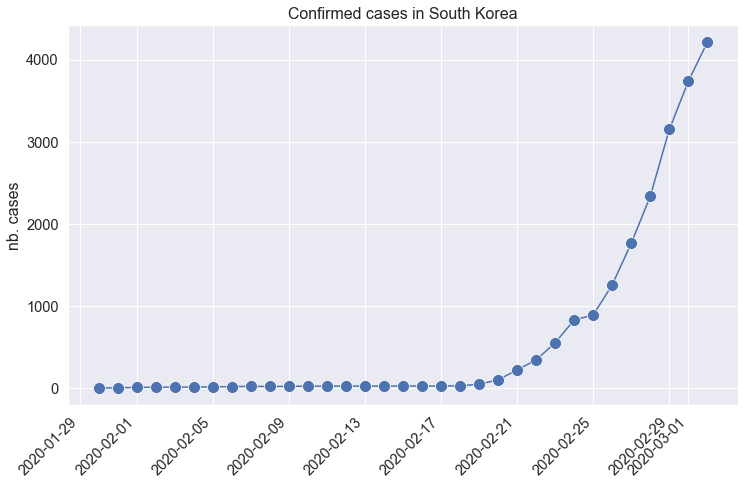

In [706]:
fig = plt.figure(figsize=(12, 7))

g = sns.lineplot(x=df_kcdc_interp.index, y="total", data=df_kcdc_interp, 
             markersize=12, marker="o");
plt.title("Confirmed cases in South Korea");
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light'
);
ax = fig.gca()
ax.set_ylabel("nb. cases");

#### Map with animation South Korea (total)

In [701]:
df_kcdc_interp["date"] = df_kcdc_interp.index
df_kcdc_interp["country"] = 'Korea, Rep.'
df_kcdc_interp["iso_alpha"] = 'KOR'
df_kcdc_interp["day"] = range(0, df_kcdc_interp.shape[0])

In [768]:
import plotly.express as px

# add animate bubble
fig = px.scatter_geo(df_kcdc_interp, locations="iso_alpha", color="total",
                     range_color=[0, 5000], text="total",
                     hover_name="country", size="total", size_max=40, 
                     animation_frame=df_kcdc_interp.index.strftime('%b %d'), 
                     projection="natural earth",
            title="COVID-19 Confirmed cases in South Korea (Total Animation)")

# add text 
fig['data'][0].update(mode='markers+text', textposition='bottom center')

# center map
fig.update_geos(lonaxis_range=[ -20.0, 20.0] \
                + df_geo_kor[df_geo_kor["area"] == "Daegu"]["lon"].values[0],
                lataxis_range=[ -10.0, 10.0] + \
                df_geo_kor[df_geo_kor["area"] == "Daegu"]["lat"].values[0],
                landcolor = 'rgb(217, 217, 217)', 
                showocean=True, oceancolor="LightBlue")

# colorize country
fig.add_trace(go.Choropleth(
        locationmode='country names',
        locations=df_kcdc_interp["country"],
        z=df_kcdc_interp["total"],
        text=df_kcdc_interp['country'],
        colorscale=[[0,'rgb(255, 245, 255)'],[1,'rgb(255, 245, 255)']],
        autocolorscale=False,
        showscale=False,
        hoverinfo='skip',
        geo='geo'
    ))

fig.update_layout(height=500, margin={"r":0,"t":50,"l":0,"b":0})

fig.show()

#### Confirmed cases by Area

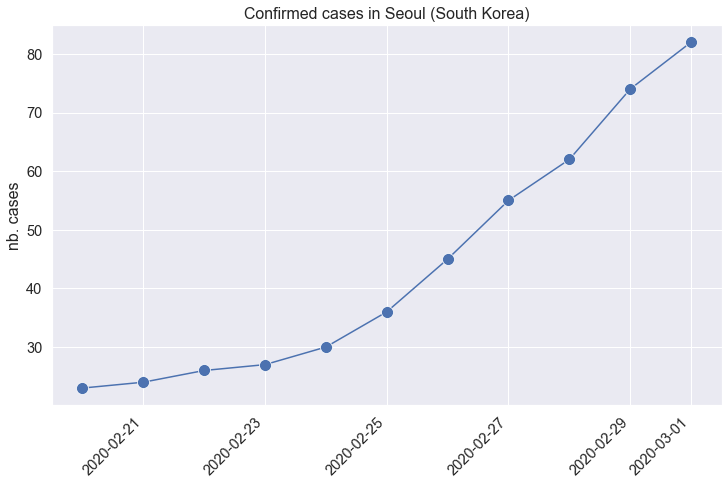

In [707]:
fig = plt.figure(figsize=(12, 7))

g = sns.lineplot(x=df_kcdc_interp.index, y="Seoul", data=df_kcdc_interp, 
             markersize=12, marker="o");
plt.title("Confirmed cases in Seoul (South Korea)");
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light'
);
ax = fig.gca()
ax.set_ylabel("nb. cases");

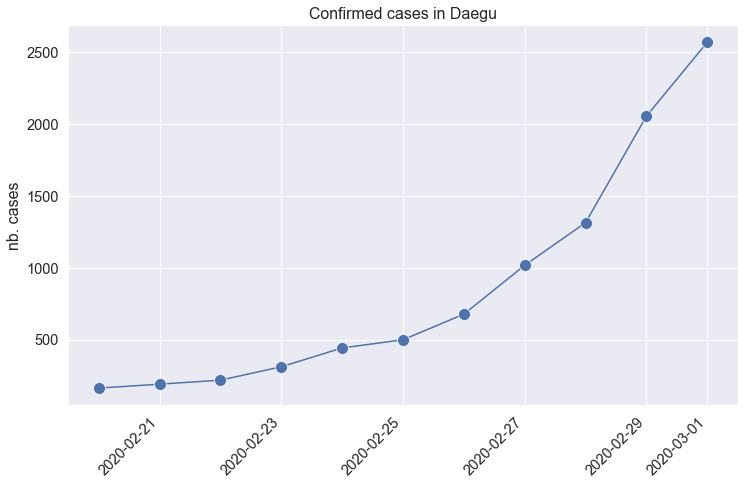

In [713]:
fig = plt.figure(figsize=(12, 7))

g = sns.lineplot(x=df_kcdc_interp.index, y="Daegu", data=df_kcdc_interp, 
             markersize=12, marker="o");
plt.title("Confirmed cases in Daegu");
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light'
);
ax = fig.gca()
ax.set_ylabel("nb. cases");

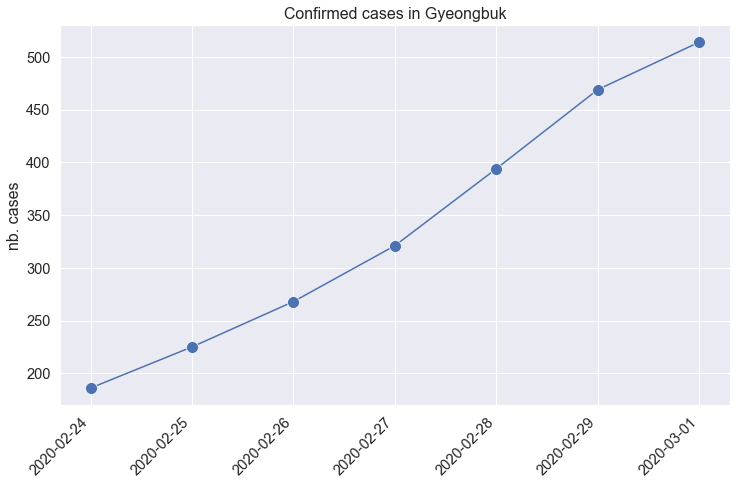

In [712]:

fig = plt.figure(figsize=(12, 7))

g = sns.lineplot(x=df_kcdc_interp.index, y="Gyeongbuk", data=df_kcdc_interp, 
             markersize=12, marker="o");
plt.title("Confirmed cases in Gyeongbuk");
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light'
);
ax = fig.gca()
ax.set_ylabel("nb. cases");

In [732]:
list_regions = LIST_AREA.copy()
list_regions.remove("Seoul")
list_regions.remove("Daegu")
list_regions.remove("Gyeongbuk")

import plotly.graph_objects as go

fig = go.Figure()
# Create and style traces
for area_curr in list_regions:
    
    fig.add_trace(go.Scatter(x=df_kcdc_interp.index, 
                         y=df_kcdc_interp[area_curr],
                    mode='lines+markers',
                    name=area_curr))

# Edit the layout
fig.update_layout(title='Confirmed cases other areas of South Korea',
                   yaxis_title='nb confirmed cases')

fig.update_xaxes(range=['2020-02-19', df_kcdc_interp.index[-1]])
#fig.update_yaxes(range=[3, 9])
fig.update_layout(legend_title='<b> Regions </b>')
fig.update_layout(legend_orientation="h")
fig.show()

#### Map : all regions of South Korea

In [746]:
df_kcdc_interp

,url,source,total,flag_add,Seoul,Busan,Daegu,Incheon,Gwangju,Daejeon,...,Chungnam,Gyeongbuk,Gyeongnam,Jeju,Cheonbuk,Cheonnam,date,country,iso_alpha,day
2020-01-30,https://www.cdc.go.kr/board/board.es?mid=a3040...,KCDC,4,False,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2020-01-30,"Korea, Rep.",KOR,0
2020-01-31,NaN,NaN,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2020-01-31,"Korea, Rep.",KOR,1
2020-02-01,https://www.cdc.go.kr/board/board.es?mid=a3040...,KCDC,12,False,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2020-02-01,"Korea, Rep.",KOR,2
2020-02-02,https://www.cdc.go.kr/board/board.es?mid=a3040...,KCDC,15,False,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2020-02-02,"Korea, Rep.",KOR,3
2020-02-03,NaN,NaN,15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2020-02-03,"Korea, Rep.",KOR,4
2020-02-04,https://www.cdc.go.kr/board/board.es?mid=a3040...,KCDC,16,False,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2020-02-04,"Korea, Rep.",KOR,5
2020-02-05,https://www.cdc.go.kr/board/board.es?mid=a3040...,KCDC,18,False,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2020-02-05,"Korea, Rep.",KOR,6
2020-02-06,https://www.cdc.go.kr/board/board.es?mid=a3040...,KCDC,23,False,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2020-02-06,"Korea, Rep.",KOR,7
2020-02-07,https://www.cdc.go.kr/board/board.es?mid=a3040...,KCDC,24,False,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2020-02-07,"Korea, Rep.",KOR,8
2020-02-08,https://www.cdc.go.kr/board/board.es?mid=a3040...,KCDC,24,False,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2020-02-08,"Korea, Rep.",KOR,9


In [788]:
df_regions = df_kcdc_interp.copy()
df_regions = df_regions.melt(id_vars=['date'], value_vars=LIST_AREA, var_name="area", 
               value_name="nb_cases")

df_regions = df_regions.join(df_geo_kor.set_index('area'), on='area')
df_regions.dropna(inplace=True, subset=["nb_cases"])
df_regions = df_regions.fillna(0)

df_regions = df_regions[df_regions["date"] > '2020-02-19']

df_regions

,date,area,nb_cases,lat,lon
21,2020-02-20,Seoul,23.0,37.564983,126.939211
22,2020-02-21,Seoul,24.0,37.564983,126.939211
23,2020-02-22,Seoul,26.0,37.564983,126.939211
24,2020-02-23,Seoul,27.0,37.564983,126.939211
25,2020-02-24,Seoul,30.0,37.564983,126.939211
...,...,...,...,...,...
555,2020-02-26,Jeju,2.0,33.488774,126.498708
556,2020-02-27,Jeju,2.0,33.488774,126.498708
557,2020-02-28,Jeju,2.0,33.488774,126.498708
558,2020-02-29,Jeju,2.0,33.488774,126.498708


In [789]:
import plotly.express as px

# add animate bubble
fig = px.scatter_geo(df_regions, lat="lat", lon="lon", color="nb_cases",
                     range_color=[0, 5000], text="nb_cases",
                     hover_name="area", size="nb_cases", size_max=40, 
                     animation_frame=df_regions["date"].dt.strftime('%b %d'), 
                     projection="natural earth",
            title="COVID-19 Confirmed cases in South Korea (Areas Animation)")

# add text 
fig['data'][0].update(mode='markers+text', textposition='bottom center')

# center map
fig.update_geos(lonaxis_range=[ -5.0, 5.0] \
                + df_geo_kor[df_geo_kor["area"] == "Daegu"]["lon"].values[0],
                lataxis_range=[ -3, 2.5] + \
                df_geo_kor[df_geo_kor["area"] == "Daegu"]["lat"].values[0],
                landcolor = 'rgb(217, 217, 217)', 
                showocean=True, oceancolor="LightBlue")

# colorize country
fig.add_trace(go.Choropleth(
        locationmode='country names',
        locations=df_kcdc_interp["country"],
        z=df_kcdc_interp["total"],
        text=df_kcdc_interp['country'],
        colorscale=[[0,'rgb(255, 245, 255)'],[1,'rgb(255, 245, 255)']],
        autocolorscale=False,
        showscale=False,
        hoverinfo='skip',
        geo='geo'
    ))

fig.update_layout(height=500, margin={"r":0,"t":50,"l":0,"b":0})

fig.show()